In [1]:
import os

path = 'lastfm-dataset-1K'

if not os.path.exists(path):

  !wget http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-1K.tar.gz
  !tar -xvzf lastfm-dataset-1K.tar.gz


In [2]:
!ls

drive  lastfm-dataset-1K  lastfm-dataset-1K.tar.gz  sample_data


In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls drive/MyDrive/data

feature_df_with_emb.csv  spotify_features.csv


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import scipy.sparse as sp
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')
%matplotlib inline

import datetime
import time 
import math
import os
%config Completer.use_jedi = False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.


In [7]:
path = "drive/MyDrive/data/feature_df_with_emb.csv"

feature_df_with_emb = pd.read_csv(path)
feature_df_with_emb = feature_df_with_emb.drop('Unnamed: 0', axis=1)

In [8]:
feature_df_with_emb.head()

,artist,track,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genres,popularity,genres_emb,emb_x,emb_y,emb_z
0,坂本龍一,Composition 0919 (Live_2009_4_15),0.806,0.413,5.0,-12.883,1.0,0.1560,0.987,0.794,0.1130,0.5290,105.089,330253.0,"['japanese soundtrack', 'japanese classical', ...",62,[7.3752766 4.8944925 0.94349271],7.375277,4.894493,0.943493
1,坂本龍一,Hibari (Live_2009_4_15),0.604,0.283,9.0,-19.811,0.0,0.0583,0.996,0.916,0.1140,0.2700,137.802,540133.0,"['japanese soundtrack', 'japanese classical', ...",62,[7.3752766 4.8944925 0.94349271],7.375277,4.894493,0.943493
2,坂本龍一,To Stanford (Live_2009_4_15),0.453,0.163,5.0,-20.922,1.0,0.0519,0.990,0.939,0.1010,0.0703,73.926,216853.0,"['japanese indie folk', 'japanese soundtrack',...",39,[7.3752766 4.8944925 0.94349271],7.375277,4.894493,0.943493
3,坂本龍一,Improvisation (Live_2009_4_15),0.217,0.012,5.0,-36.464,1.0,0.0376,0.991,0.859,0.0866,0.0376,80.714,384707.0,"['japanese soundtrack', 'japanese classical', ...",62,[7.3752766 4.8944925 0.94349271],7.375277,4.894493,0.943493
4,坂本龍一,Glacier (Live_2009_4_15),0.518,0.213,9.0,-28.790,0.0,0.2090,0.869,0.898,0.1030,0.0920,104.191,580707.0,"['japanese soundtrack', 'japanese classical', ...",62,[7.3752766 4.8944925 0.94349271],7.375277,4.894493,0.943493


In [9]:
# Load the dataset
df = pd.read_table('lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv', lineterminator='\n', warn_bad_lines=True, names=['user', 'timestamp', 'artist-id', 'artist', 'song-id', 'song'])
df_profile = pd.read_csv('lastfm-dataset-1K/userid-profile.tsv', sep='\t', error_bad_lines=False, warn_bad_lines=True, skiprows=1, names=['user', 'gender', 'age', 'country', 'signup'])

In [10]:
# Check if some songs share a common ID
grouped = df[['song-id', 'song']].groupby(['song-id']).nunique()

In [11]:
# Get rows with song names containing multiple rows
duplicated = df.loc[df['song-id'].isin(grouped[grouped['song'] > 1].index)]
duplicated = duplicated.drop(columns=['user', 'timestamp', 'artist', 'artist-id'])
containis_extra_rows = duplicated.apply(lambda x: pd.Series({'id': x[0], 'song': x[1], 'flag':'\n' in x[1]}), axis=1)
containis_extra_rows = containis_extra_rows.loc[containis_extra_rows['flag']]

In [12]:
# Iterate over those 5k rows to get the extra rows and correct the song name
for index, row in containis_extra_rows.iterrows():
    row_break = row['song'].split('\n', 1)
    song_name = row_break[0]
    df.loc[df['song-id'] == row['id'], 'song'] = song_name
    
    tsv = StringIO(row_break[1])
    df_extra = pd.read_csv(tsv, sep="\t", warn_bad_lines=True, names=['user', 'timestamp', 'artist-id', 'artist', 'song-id', 'song'])
    df = df.append(df_extra, ignore_index=True)

### Fix names

In [13]:
# Check if some songs share a common ID
grouped = df[['song-id', 'song']].groupby(['song-id']).nunique()

In [14]:
# Check how many ids has more than 1 song name
grouped[grouped['song'] > 1].shape[0]

200

In [15]:
ids_to_be_fixed = grouped[grouped['song'] > 1].index

In [16]:
df = df.set_index('song-id')

In [17]:
map_to_fix = df.groupby(df.index)['song'].head(1)

In [18]:
df.loc[ids_to_be_fixed, 'song'] = df.loc[ids_to_be_fixed].reset_index()['song-id'].map(lambda x: map_to_fix[x])
df = df.reset_index()

### Create matrix

In [135]:
matrix_init = df.groupby(['user', 'artist', 'song']).count()

In [136]:
matrix_init = matrix_init['timestamp']
matrix_init = matrix_init.map(lambda x: np.log(x))

In [137]:
matrix_init = matrix_init.reset_index()

In [138]:
def rating_scaler(row):
    row_array = np.array(row)
    lower_bound, new_range= 3, 7
    min_, max_ = row_array.min(), row_array.max()
    old_range = max_ - min_
    
    
    scaled_row = (new_range * (row_array - min_)) / (old_range + 1e-6)  + lower_bound
    scaled_row[scaled_row == 3] = 0
    return pd.Series(scaled_row)

In [139]:
matrix_init_scaled = matrix_init.groupby('user')['timestamp'].apply(rating_scaler)

In [140]:
matrix_init['timestamp'] = matrix_init_scaled.reset_index()['timestamp']

In [141]:
matrix_init['timestamp'].describe()

count    4.613822e+06
mean     2.817463e+00
std      2.828400e+00
min      0.000000e+00
25%      0.000000e+00
50%      3.937382e+00
75%      5.201265e+00
max      9.999999e+00
Name: timestamp, dtype: float64

In [142]:
(matrix_init['timestamp'] == 0).sum() / matrix_init.shape[0]

0.47684197613171897

In [143]:
feature_df_with_emb['item'] = feature_df_with_emb.apply(lambda row: row[0]+'-'+row[1], axis=1)

### Merge data

In [144]:
matrix_init = matrix_init.rename({'timestamp':'rating', 'song':'track'}, axis=1)

In [145]:
matrix_extended = matrix_init.merge(feature_df_with_emb, on=['artist', 'track'])

In [146]:
matrix_extended.head()

,user,artist,track,rating,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genres,popularity,genres_emb,emb_x,emb_y,emb_z,item
0,user_000001,2562,Basin Dub,4.142058,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub
1,user_000451,2562,Basin Dub,4.080958,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub
2,user_000471,2562,Basin Dub,0.000000,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub
3,user_000508,2562,Basin Dub,4.976012,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub
4,user_000515,2562,Basin Dub,3.973598,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub


### Filter the dataset

In [147]:
matrix_extended.groupby('user').count()['rating'].describe()

count      992.000000
mean      4367.426411
std       5152.289753
min          1.000000
25%       1265.500000
50%       2945.000000
75%       5524.500000
max      65246.000000
Name: rating, dtype: float64

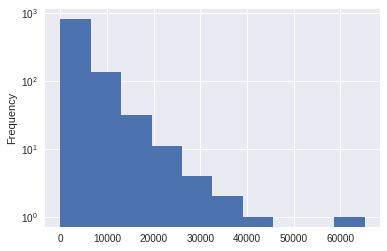

In [148]:
matrix_extended.groupby('user').count()['rating'].plot.hist()
plt.yscale('log')
plt.show()

In [149]:
matrix_extended.groupby('item').count()['rating'].describe()

count    929536.000000
mean          4.660914
std          10.819621
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         346.000000
Name: rating, dtype: float64

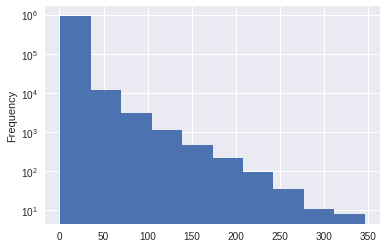

In [150]:
matrix_extended.groupby('item').count()['rating'].plot.hist()
plt.yscale('log')
plt.show()

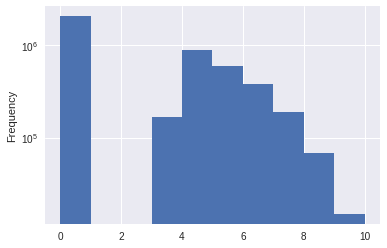

In [151]:
matrix_extended['rating'].plot.hist()
plt.yscale('log')
plt.show()

In [152]:
items_app = matrix_extended.groupby('item').count()['rating']
items_app = items_app.loc[items_app > 3.99].index
matrix_sampled = matrix_extended.copy()
matrix_sampled = matrix_sampled.set_index('item')
matrix_sampled = matrix_sampled.loc[items_app]
matrix_sampled = matrix_sampled.reset_index()
matrix_sampled = matrix_sampled.sample(frac=1)

In [153]:
matrix_sampled.groupby('user').count()['rating'].describe()

count      991.000000
mean      3399.972755
std       3809.005245
min          3.000000
25%       1064.500000
50%       2344.000000
75%       4265.000000
max      47788.000000
Name: rating, dtype: float64

### Sample Users

In [154]:
# no_users = 200
# users_list = matrix_extended.user.unique()
# users_sampled = np.random.choice(users_list, replace=False, size=no_users)
# matrix_sampled = matrix_extended.copy()
# matrix_sampled = matrix_sampled.set_index('user')
# matrix_sampled = matrix_sampled.loc[users_sampled]
# matrix_sampled = matrix_sampled.reset_index()
# matrix_sampled = matrix_sampled.sample(frac=1)
# matrix_sampled['item'] = matrix_sampled.apply(lambda row: row[1]+'-'+row[2], axis=1)

In [155]:
matrix_sampled.head()

,item,user,artist,track,rating,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genres,popularity,genres_emb,emb_x,emb_y,emb_z
1001396,Fischerspooner-Everything To Gain,user_000691,Fischerspooner,Everything To Gain,0.000000,0.760,0.726,5.0,-6.880,1.0,0.0383,0.002580,0.682000,0.0682,0.0693,130.008,253005.0,"['electroclash', 'alternative dance', 'new rav...",46,[5.79049085 7.24413655 2.5472601 ],5.790491,7.244137,2.547260
1716105,Meat Beat Manifesto-Dog Star,user_000870,Meat Beat Manifesto,Dog Star,5.825886,0.598,0.958,10.0,-12.889,0.0,0.0518,0.001210,0.252000,0.5590,0.3350,123.108,311627.0,"['acid house', 'trip hop', 'electro-industrial...",35,[5.85422525 5.69914685 2.693344 ],5.854225,5.699147,2.693344
1847515,Ms. Dynamite-Brother,user_000961,Ms. Dynamite,Brother,0.000000,0.793,0.427,6.0,-10.927,0.0,0.2190,0.183000,0.000026,0.1290,0.5080,96.088,214640.0,"['hip pop', 'uk garage']",56,[4.98242985 6.94927435 3.93792845],4.982430,6.949274,3.937928
457766,Britney Spears-Radar,user_000872,Britney Spears,Radar,4.246725,0.642,0.722,4.0,-4.845,0.0,0.1670,0.293000,0.000000,0.3370,0.5130,127.959,229213.0,"['post-teen pop', 'dance pop', 'pop']",86,[5.0493402 7.54688585 3.666668 ],5.049340,7.546886,3.666668
1939239,Nightwish-Cadence Of Her Last Breath,user_000348,Nightwish,Cadence Of Her Last Breath,4.078274,0.507,0.882,7.0,-4.848,0.0,0.0699,0.000698,0.000106,0.2990,0.1380,101.991,254955.0,"['gothic metal', 'power metal', 'opera metal',...",71,[ 8.020621 8.743253 -0.7073961],8.020621,8.743253,-0.707396


In [156]:
matrix_sampled['user_id'] = matrix_sampled['user'].astype('category').cat.codes
matrix_sampled['item_id'] = matrix_sampled['item'].astype('category').cat.codes

In [157]:
X = matrix_sampled[['user_id', 
              'item_id',
              'danceability',
              'energy',
              'speechiness', 
              'acousticness', 
              'instrumentalness', 
              'liveness',
              'valence', 
              'tempo', 
              'popularity', 
              'emb_x', 
              'emb_y',
              'emb_z']]
y = matrix_sampled['rating']
groups = matrix_sampled['user_id']

In [158]:
# Change splitting to be by index using https://stackoverflow.com/questions/53490497/getting-validation-set-from-train-set-by-using-percentage-from-groupby-in-pand
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=groups)

In [159]:
no_users, no_items, no_factors = matrix_sampled['user_id'].nunique(), matrix_sampled['item_id'].nunique(), 100

In [160]:
no_users

991

In [161]:
no_items

246166

### Models

In [162]:
def create_shallow_model(no_factors, no_users, no_items):
    # User branch
    user_id = tf.keras.layers.Input(shape=[1], name='user_id')
    user_matrix = tf.keras.layers.Embedding(no_users+1, no_factors, name='user_matrix')(user_id)
    user_vector = tf.keras.layers.Flatten(name='user_vector')(user_matrix)
    # Item branch
    item_id = tf.keras.layers.Input(shape=[1], name='item_id')
    item_matrix = tf.keras.layers.Embedding(no_items+1, no_factors, name='item_matrix')(item_id)
    item_vector = tf.keras.layers.Flatten(name='item_vector')(item_matrix)
    # Dot product 
    vectors_product = tf.keras.layers.dot([user_vector, item_vector], axes=1, normalize=False)
    # Model definition
    model = tf.keras.models.Model(inputs=[user_id, item_id], outputs=[vectors_product], name='shallow_model')
    return model

In [163]:
model = create_shallow_model(no_factors, no_users, no_items)

In [164]:
model.summary()

Model: "shallow_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_matrix (Embedding)         (None, 1, 100)       99200       user_id[0][0]                    
__________________________________________________________________________________________________
item_matrix (Embedding)         (None, 1, 100)       24616700    item_id[0][0]                    
______________________________________________________________________________________

In [165]:
def create_deep_model(no_factors, no_users, no_items):
    # User branch
    user_id = tf.keras.layers.Input(shape=[1], name='user_id')
    user_matrix = tf.keras.layers.Embedding(no_users+1, no_factors, name='user_matrix')(user_id)
    user_vector = tf.keras.layers.Flatten(name='user_vector')(user_matrix)
    # Item branch
    item_id = tf.keras.layers.Input(shape=[1], name='item_id')
    item_matrix = tf.keras.layers.Embedding(no_items+1, no_factors, name='item_matrix')(item_id)
    item_vector = tf.keras.layers.Flatten(name='item_vector')(item_matrix)
    # Concantenation
    vectors_concat = tf.keras.layers.Concatenate()([user_vector, item_vector])
    vectors_concat_dropout = tf.keras.layers.Dropout(0.2)(vectors_concat)
    # Backbone 
    dense_1 = tf.keras.layers.Dense(64,name='fc3')(vectors_concat_dropout)
    dropout_1 = tf.keras.layers.Dropout(0.2,name='d3')(dense_1)
    dense_2 = tf.keras.layers.Dense(32,name='fc4', activation='relu')(dropout_1)
    dropout_2 = tf.keras.layers.Dropout(0.2,name='d4')(dense_2)
    dense_3 = tf.keras.layers.Dense(16,name='fc5', activation='relu')(dropout_2)
    dropout_3 = tf.keras.layers.Dropout(0.2,name='d5')(dense_3)
    dense_4 = tf.keras.layers.Dense(8,name='fc6', activation='relu')(dropout_3)
    dense_4_output = tf.keras.layers.Dense(1, activation='relu', name='activation')(dense_4)
    # Model definition
    model = tf.keras.models.Model(inputs=[user_id, item_id], outputs=[dense_4_output], name='deep_model')
    return model

In [166]:
model = create_deep_model(no_factors, no_users, no_items)

### Model training

In [167]:
# Input-output data definition
X_train_arr = [X_train.user_id, X_train.item_id]

# Model creation
model = create_deep_model(no_factors, no_users, no_items)

# Model compiling 
model.compile(loss=tf.keras.losses.MeanSquaredError())

# Model training
model.fit(X_train_arr, y_train, epochs=10, batch_size=2048, shuffle=True)

Epoch 1/10
1317/1317 [==============================] - 119s 89ms/step - loss: 7.3206
Epoch 2/10
1317/1317 [==============================] - 118s 90ms/step - loss: 6.7386
Epoch 3/10
1317/1317 [==============================] - 118s 89ms/step - loss: 6.5572
Epoch 4/10
1317/1317 [==============================] - 118s 89ms/step - loss: 6.3904
Epoch 5/10
1317/1317 [==============================] - 118s 90ms/step - loss: 6.2641
Epoch 6/10
1317/1317 [==============================] - 117s 89ms/step - loss: 6.1551
Epoch 7/10
1317/1317 [==============================] - 118s 89ms/step - loss: 6.0544
Epoch 8/10
1317/1317 [==============================] - 118s 89ms/step - loss: 5.9641
Epoch 9/10
1317/1317 [==============================] - 118s 89ms/step - loss: 5.8795
Epoch 10/10
1317/1317 [==============================] - 118s 89ms/step - loss: 5.7988


### Prediction

In [168]:
# Predictions in the training set
# X_train = [X_train.user_id, X_train.item_id]
y_train_pred = model.predict(X_train_arr, batch_size=2048)

In [169]:
X_test.head()

,user_id,item_id,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,emb_x,emb_y,emb_z
1925925,585,146305,0.483,0.774,0.0377,0.16700,0.205000,0.3330,0.560,112.646,69,5.695112,7.734896,0.901376
2724999,785,201774,0.625,0.707,0.0316,0.10900,0.000101,0.0486,0.751,158.012,32,6.047996,8.320479,1.834515
2189316,873,164163,0.576,0.986,0.0691,0.00164,0.000000,0.3720,0.840,104.029,33,6.382213,6.987065,1.502415
275769,16,20745,0.537,0.404,0.0292,0.37900,0.000003,0.2340,0.378,84.436,30,NaN,NaN,NaN
795845,681,58785,0.440,0.186,0.0305,0.89500,0.399000,0.1050,0.178,104.342,62,5.981853,8.493409,1.409856


In [170]:
# Predictions in the test set
X_test_arr = [X_test.user_id, X_test.item_id]
y_test_pred = model.predict(X_test_arr, batch_size=2048)

### Evaluation

In [171]:
from sklearn.metrics import mean_squared_error
print('Train RMSE:', mean_squared_error(y_train.values, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test.values, y_test_pred, squared=False))

Train RMSE: 2.344488728287637
Test RMSE: 2.6733280802030857


In [172]:
def get_test_predictions(model, test_ratings):
  predictions_li = []
  for user_id, user_test_rating in tqdm(test_ratings.groupby('user_id'), position=0, leave=True):
        # Retrieve the unseen items
        user_df = test_ratings[(test_ratings['user_id'] == user_id)]
        test_pids = user_df['item_id'].values
        relevant_pids = set(user_df.loc[user_df['rating'] > 1, 'item_id'].values)
        if len(relevant_pids) == 0:
          continue
        # Create testing dataframe
        test_df = pd.DataFrame({'user_id': user_id, 'item_id': test_pids})
        test_set = [test_df.user_id, test_df.item_id]
        # Make rating predictions for all items for that user
        predictions = model.predict(test_set, batch_size=2048)
        # predictions = pred_func(model, user_id, pid_array, train_ratings)
        predictions = predictions.reshape(-1)
        irrelevant_pids = set(test_pids).difference(relevant_pids)
        predictions_relevant = predictions[user_df['rating'] > 1]
        predictions_irrelevant = predictions[user_df['rating'] == 0]
        predictions_dict = {'user_id': user_id,
                            'predictions': predictions,
                            'test_pids': test_pids,
                            'relevant_pids': relevant_pids,
                            'irrelevant_pids': irrelevant_pids,
                            'predictions_relevant': predictions_relevant,
                            'predictions_irrelevant': predictions_irrelevant}
        predictions_li.append(predictions_dict)

  return pd.DataFrame(predictions_li)


In [173]:
X_test_arr = np.array(X_test_arr)
test_ratings = pd.DataFrame({'user_id': X_test_arr[0, :], 'item_id':X_test_arr[1, :], 'rating': y_test})
predictions_df = get_test_predictions(model, test_ratings)

100%|██████████| 991/991 [00:59<00:00, 16.66it/s]


In [174]:
# Predictions analysis (Used to debug the recommender system prediction range)
predictions_df['mean'] = predictions_df['predictions'].map(lambda a: a.mean())
predictions_df['median'] = predictions_df['predictions'].map(lambda a:np.median(a))
predictions_df['min'] = predictions_df['predictions'].map(lambda a: a.min())
predictions_df['max'] = predictions_df['predictions'].map(lambda a: a.max())
predictions_df['25th'] = predictions_df['predictions'].map(lambda a: np.percentile(a, q=25))
predictions_df['75th'] = predictions_df['predictions'].map(lambda a: np.percentile(a, q=75))
# Predictions relevant analysis (Used to debug the recommender system prediction range)
predictions_df['mean_relevant'] = predictions_df['predictions_relevant'].map(lambda a: a.mean())
predictions_df['median_relevant'] = predictions_df['predictions_relevant'].map(lambda a:np.median(a))
predictions_df['min_relevant'] = predictions_df['predictions_relevant'].map(lambda a: a.min())
predictions_df['max_relevant'] = predictions_df['predictions_relevant'].map(lambda a: a.max())
predictions_df['25th_relevant'] = predictions_df['predictions_relevant'].map(lambda a: np.percentile(a, q=25))
predictions_df['75th_relevant'] = predictions_df['predictions_relevant'].map(lambda a: np.percentile(a, q=75))
# Predictions irrelevant analysis (Used to debug the recommender system prediction range)
predictions_df['mean_irrelevant'] = predictions_df['predictions_irrelevant'].map(lambda a: a.mean())
predictions_df['median_irrelevant'] = predictions_df['predictions_irrelevant'].map(lambda a:np.median(a))
predictions_df['min_irrelevant'] = predictions_df['predictions_irrelevant'].map(lambda a: a.min())
predictions_df['max_irrelevant'] = predictions_df['predictions_irrelevant'].map(lambda a: a.max())
predictions_df['25th_irrelevant'] = predictions_df['predictions_irrelevant'].map(lambda a: np.percentile(a, q=25))
predictions_df['75th_irrelevant'] = predictions_df['predictions_irrelevant'].map(lambda a: np.percentile(a, q=75))

In [175]:
def plot_predictions(predictions_df):
  pred_arr = [predictions_df[['predictions_relevant']].apply(lambda x: np.hstack(x), axis=0).values.reshape(-1),
              predictions_df[['predictions_irrelevant']].apply(lambda x: np.hstack(x), axis=0).values.reshape(-1)]

  f, ax = plt.subplots(1, 1)
  ax.set_title('Predictions distribution', color='C0')
  c = 'red'
  bplot = plt.boxplot(pred_arr, labels=['Relevant', 'Irrelevant'], vert=True, patch_artist=True)
  # fill with colors
  colors = ['C4', 'C2']
  for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

  for median in bplot['medians']:
    median.set(color='k', linewidth=1.5)

  plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


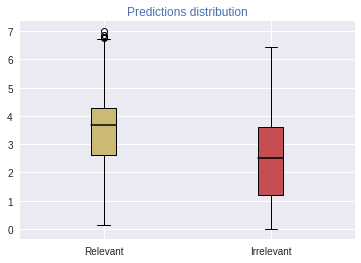

In [176]:
plot_predictions(predictions_df)

In [177]:
row = predictions_df.iloc[48]

In [178]:
predictions = row[1]
test_pids = row[2]
relevant_pids = set(row[3])
# Sort the items and het the top k
top_k = predictions > 2
top_k_items = set(np.array(test_pids)[top_k])

In [188]:
def precision_at_k(predictions_df):
    precisions = []
    # For each user
    for row in predictions_df.iterrows():
      predictions = row[1][1]
      test_pids = row[1][2]
      relevant_pids = set(row[1][3])
      if len(relevant_pids) == 0:
          continue
      # Sort the items and het the top k
      top_k = predictions > 2.5
      if top_k.sum() == 0:
         precisions.append(0)
         continue
      top_k_items = set(np.array(test_pids)[top_k])
      # Compute precision as per definition
      precisions.append(len(top_k_items & relevant_pids) / top_k.sum())
    return precisions

In [189]:
precisions = precision_at_k(predictions_df)

In [190]:
np.mean(precisions), np.std(precisions)

(0.5631812304105139, 0.1851009344036276)

In [191]:
### EXERCISE CELL ###
def recall_at_k(predictions_df):
    recalls = []
    # For each user
    for row in predictions_df.iterrows():
      predictions = row[1][1]
      test_pids = row[1][2]
      relevant_pids = set(row[1][3])
      if len(relevant_pids) == 0:
          continue
      # Sort the items and het the top k
      top_k = predictions > 2.5
      if top_k.sum() == 0:
         recalls.append(0)
         continue
      top_k_items = set(np.array(test_pids)[top_k])
      recalls.append(len(top_k_items & relevant_pids) / len(relevant_pids))
    return recalls

In [192]:
recalls = recall_at_k(predictions_df)

In [193]:
np.mean(recalls), np.std(recalls)

(0.6792666362128108, 0.28205400768773636)

In [185]:
### EXERCISE CELL ###
def map_at_k(model, test_ratings, k=100):
    maps = []
    for row in predictions_df.iterrows():
      predictions = row[1][1]
      test_pids = row[1][2]
      relevant_pids = set(row[1][3])
      if len(relevant_pids) == 0:
          continue
      partial_maps = []
      top_k = list(np.argsort(predictions)[:k])
      top_k_items = np.array(test_pids)[top_k]
      for rank, item_id in enumerate(top_k_items):
          if item_id in relevant_pids:
              partial_maps.append(len(set(top_k_items[:rank+1]) & relevant_pids) / float(rank+1))
      maps.append(.0 if len(partial_maps) == 0 else np.sum(partial_maps) / float(k))
    return maps

In [186]:
maps = map_at_k(model, test_ratings, k=100)

In [187]:
np.mean(maps), np.std(maps)

(0.19952803451640708, 0.17114467331641142)